In [1]:
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as model
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import tarfile
from torch.nn import DataParallel
from pathlib import Path
!pip install torchsummary
from torchsummary import summary
import os
import torch.nn as nn
from PIL import Image
import math
import time
print(torch.__version__)

1.13.0


In [2]:
# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [3]:
class FocalLoss(torch.nn.Module):
    def __init__(self, weight=None, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [4]:
class ArcFaceLoss(torch.nn.Module):
    """Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin

            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = torch.nn.Parameter(torch.FloatTensor(out_features, in_features))
        torch.nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, feature, label= None):
        # Normalize embeddings and weights
        feature = F.normalize(feature)
        weights = F.normalize(self.weight)

        # Compute the logit
        cos_theta = F.linear(feature, weights)
        
        if (label is None):
            return cos_theta

        # Find the angle between the weight and feature
        theta = torch.acos(cos_theta)

        # Add angular margin penalty
        marginal_target_logit = torch.cos(theta + self.m)
        
        marginal_target_logit = torch.where(cos_theta > self.th, marginal_target_logit, cos_theta - self.mm)

        # One-hot encoding
        #one_hot = torch.zeros(cos_theta.size(), device=device)
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        # Compute class wise similarity score through element wise multiplication of one_hot ground truth and the marginal target logit
        score = (one_hot * marginal_target_logit) + ((1.0 - one_hot) * cos_theta)
        #score = torch.mul(marginal_target_logit, one_hot)

        # Rescale to s
        score *= self.s

        return score


In [5]:
# transform into tensors
transform_train = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [6]:
# Make the LFW test and train datasets and put in dataloader for batching
lfwdataset_train = torchvision.datasets.LFWPeople(root = "kaggle/input/lfwpeople", split= "train", transform=transform_train, download=True)
lfwdataset_test = torchvision.datasets.LFWPeople(root = "kaggle/input/lfwpeople", split= "test", transform=transform, download=True)
lfwdataset_val = torchvision.datasets.LFWPeople(root = "kaggle/input/lfwpeople", split= "10fold", transform=transform, download=True)

data_loader_valid = DataLoader(lfwdataset_val, batch_size= 32, shuffle= True, num_workers=0, collate_fn= None, pin_memory= False)
data_loader_train = DataLoader(lfwdataset_train, batch_size= 32, shuffle= True, num_workers=0, collate_fn= None, pin_memory= False)
data_loader_test = DataLoader(lfwdataset_test, batch_size= 32, shuffle= True, num_workers=0, collate_fn= None, pin_memory= False)

num_classes_train = len(set(lfwdataset_train.targets))
num_classes_validation = len(set(lfwdataset_val.targets))
num_classes_test = len(set(lfwdataset_test.targets))
#num_classes_LFW = 5749
num_classes_LFW = len(set(lfwdataset_val.targets))
print(len(set(lfwdataset_train.targets)))
print(len(set(lfwdataset_test.targets)))
print(len(set(lfwdataset_val.targets)))

  0%|          | 0/243346528 [00:00<?, ?it/s]

Extracting kaggle/input/lfwpeople/lfw-py/lfw-funneled.tgz to kaggle/input/lfwpeople/lfw-py


  0%|          | 0/66403 [00:00<?, ?it/s]

  0%|          | 0/94727 [00:00<?, ?it/s]

Using downloaded and verified file: kaggle/input/lfwpeople/lfw-py/lfw-funneled.tgz
Extracting kaggle/input/lfwpeople/lfw-py/lfw-funneled.tgz to kaggle/input/lfwpeople/lfw-py


  0%|          | 0/28334 [00:00<?, ?it/s]

Using downloaded and verified file: kaggle/input/lfwpeople/lfw-py/lfw-names.txt
Using downloaded and verified file: kaggle/input/lfwpeople/lfw-py/lfw-funneled.tgz
Extracting kaggle/input/lfwpeople/lfw-py/lfw-funneled.tgz to kaggle/input/lfwpeople/lfw-py


  0%|          | 0/94770 [00:00<?, ?it/s]

Using downloaded and verified file: kaggle/input/lfwpeople/lfw-py/lfw-names.txt
4038
1711
5749


In [7]:
#Implemenet CNN Baacosh_ckbone
Path_resnet = Path('/kaggle/working/resnet50_weights.pth') 
# if (Path_resnet.is_file()):
#     models = model.resnet50()
#     # Freeze All CNN Layers (Stop all learning in all layers)
#     for param in models.parameters():
#         param.requires_grad = False

#     # Change the final layer (unfreeze fc layer)
#     models.avgpool = torch.nn.Identity()
#     models.fc = torch.nn.Sequential(
#     torch.nn.BatchNorm1d(num_features= 100352),
#     torch.nn.Dropout(p=0.5),
#     torch.nn.Linear(in_features= 100352, out_features=512, bias=True),
#     torch.nn.BatchNorm1d(num_features=512)
#     )
#     models.fc.requires_grad = True
#     models = DataParallel(models)
#     models.load_state_dict(torch.load('/kaggle/working/resnet50_weights.pth'))
#     print(models.state_dict())
# else:
weights = model.ResNet50_Weights.DEFAULT
models = model.resnet50(weights = weights)


#Freeze All CNN Layers (Stop all learning in all layers)
for param in models.parameters():
    param.requires_grad = False

# Change the final layer (unfreeze fc layer)
models.avgpool = torch.nn.Identity()
models.fc = torch.nn.Sequential(
torch.nn.BatchNorm1d(num_features= 32768, track_running_stats= True),
torch.nn.Dropout(p=0.5),
torch.nn.Linear(in_features= 32768, out_features=512, bias=True),
torch.nn.BatchNorm1d(num_features=512, track_running_stats= True)
)
models.fc.requires_grad = True
models = DataParallel(models)

models.to(device)
models

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [8]:
Path_arcface = Path('/kaggle/working/arcface_weights.pth')
# if (Path_arcface.is_file()):
#     metric_fc = ArcFaceLoss(512, num_classes_LFW, 30.0, 0.5)
#     metric_fc = DataParallel(metric_fc)
#     metric_fc.load_state_dict(torch.load('/kaggle/working/arcface_weights.pth'))
# else:
metric_fc = ArcFaceLoss(512, num_classes_LFW, 64.0, 0.5)
metric_fc = DataParallel(metric_fc)
metric_fc.requires_grad = True
metric_fc.to(device)
print(metric_fc.state_dict())
# Analyze model parameters and layers
#summary(models, (3, 112, 112))

OrderedDict([('module.weight', tensor([[-0.0112, -0.0193, -0.0271,  ..., -0.0040, -0.0213, -0.0270],
        [ 0.0203, -0.0292, -0.0151,  ...,  0.0068,  0.0158,  0.0161],
        [-0.0027,  0.0204, -0.0063,  ..., -0.0002,  0.0190,  0.0267],
        ...,
        [-0.0039,  0.0151, -0.0108,  ...,  0.0087, -0.0051, -0.0077],
        [ 0.0050,  0.0041,  0.0133,  ..., -0.0213,  0.0230, -0.0003],
        [ 0.0262,  0.0141,  0.0055,  ...,  0.0043, -0.0042,  0.0037]],
       device='cuda:0'))])


In [9]:
# Focal loss is an improved method of Cross Entropy that can focus on scaling the harder cases then the easier cases
#Loss = torch.nn.CrossEntropyLoss().to(device)
Loss = FocalLoss(gamma= 2).to(device)
Loss.requires_grad = True

In [10]:
# Setup Optimizer and Scheduler
optimizer = torch.optim.SGD([{'params': models.parameters()},
                              {'params': metric_fc.parameters()}],
                              lr = 1e-1, weight_decay= 5e-4, momentum= 0.9)  # Can use Adam or SGD
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones= [30, 80, 120, 170], gamma= 0.1)



In [11]:
# Train Model with Provided ArcFace 
start = time.time()
history = []
best_acc = 0.0


for epoch in range(200):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch + 1, 10))

    # Set model to train mode
    models.train()

  #  Step through scheduler
    scheduler.step()

    train_loss = 0.0
    train_acc = 0.0 

    valid_loss = 0.0
    valid_acc = 0.0


    for i, (images, labels) in enumerate(data_loader_train):
        # Put tensors into device to run CUDA
        images, labels = images.to(device), labels.to(device)
        
        # Run Resnet50 on images to compute the embedding of size 512
        embeddings = models(images)

        # Push this embedding to our Arcface fc output layer
        output = metric_fc(embeddings, labels)
        
        # Calculate loss
        loss = Loss(output, labels)

        # Clean existing gradients
        optimizer.zero_grad()
        
        # Backprop the gradients
        loss.backward()

        # Update Parameters after backprop
        optimizer.step()
        

        # Accumulate loss
        train_loss += loss.item()

        # Accuracy prediction
        ret, predictions = torch.max(output.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Conver correct_counts to float then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
  
        # Compute the total accuracy in the whole batch and add to train_acc
        train_acc += acc.item()
        if (i % 100 == 0):
          #print('Predictions: {}, Truth: {}'.format(output, labels))
          #print(correct_counts)
          print('Batch #: [{:03d}/{}], Train Loss: {}, Train Accuracy: {}'
                  .format(i+1, len(data_loader_train), train_loss / (i+1), train_acc / (i + 1)))
      

    
    # Run Validation 
    with torch.no_grad():
        print("Run Validation:")
        # Set to evaluation mode
        models.eval()

        valid_loss = 0.0
        valid_acc = 0.0

        for j, (images, labels) in enumerate(data_loader_valid):
            # Put tensors into device to run CUDA
            images, labels = images.to(device), labels.to(device)

            # Run Resnet50 on images to compute the output feature
            embeddings = models(images)

            # Push this embedding to our Arcface fc output layer
            output = metric_fc(embeddings)
            
            # Calculate loss
            loss = Loss(output, labels)

            # Calculate the total loss for the batch and add it to valid_loss
            valid_loss += loss.item()

            # Accuracy prediction
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute the total accuracy in the whole batch and add to train_acc
            valid_acc += acc.item()
            if (j % 100 == 0):
              print('Validation Batch #: {:03d}, Validation Loss: {}, Validation Accuracy: {}'
              .format(j+1, valid_loss / (j + 1), valid_acc / (j + 1)))
    history.append({'loss': train_loss / len(data_loader_train), 'acc': train_acc / len(data_loader_train), 'val_loss': valid_loss / len(data_loader_valid), 'val_acc': valid_acc / len(data_loader_valid)})
   

Epoch: 1/10


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Batch #: [001/298], Train Loss: 42.20660400390625, Train Accuracy: 0.0
Batch #: [101/298], Train Loss: 56.3073355419801, Train Accuracy: 0.0
Batch #: [201/298], Train Loss: 53.47467745121439, Train Accuracy: 0.0
Run Validation:
Validation Batch #: 001, Validation Loss: 8.531702995300293, Validation Accuracy: 0.125
Validation Batch #: 101, Validation Loss: 8.480857811351814, Validation Accuracy: 0.16274752475247525
Validation Batch #: 201, Validation Loss: 8.479294534939438, Validation Accuracy: 0.16355721393034825
Validation Batch #: 301, Validation Loss: 8.478934658722228, Validation Accuracy: 0.16590531561461794
Validation Batch #: 401, Validation Loss: 8.479626291707865, Validation Accuracy: 0.1647443890274314
Epoch: 2/10
Batch #: [001/298], Train Loss: 41.64689254760742, Train Accuracy: 0.0
Batch #: [101/298], Train Loss: 38.807989932522915, Train Accuracy: 0.0
Batch #: [201/298], Train Loss: 38.25010098509527, Train Accuracy: 0.0
Run Validation:
Validation Batch #: 001, Validation

In [12]:
# Save Weights from metric_fc and resnet50
torch.save(models.state_dict(), '/kaggle/working/resnet50_weights2.pth')
torch.save(metric_fc.state_dict(), '/kaggle/working/arcface_weights2.pth')
print("Weights")

Weights


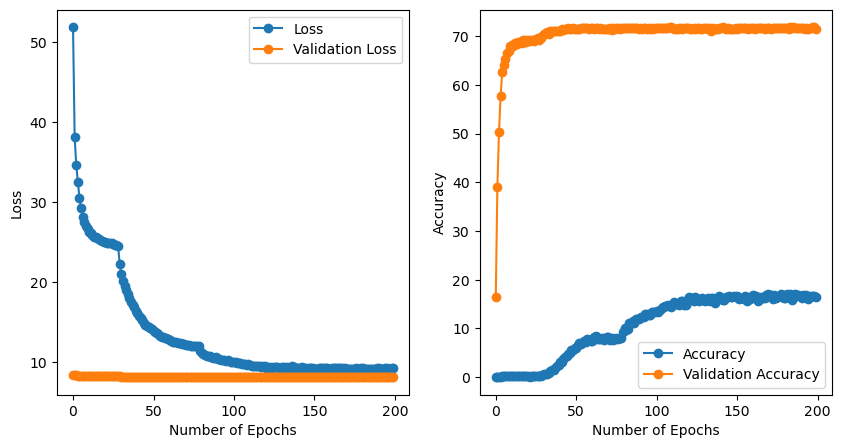

In [13]:
# Visualize the training and validation results
accuracy = [res['acc'] for res in history]
losses = [res['loss'] for res in history]
val_accuracy = [res['val_acc'] for res in history]
val_losses = [res['val_loss'] for res in history]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(losses, '-o', label = 'Loss')
ax1.plot(val_losses, '-o', label = 'Validation Loss')
ax1.set_xlabel("Number of Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
ax2.set_xlabel("Number of Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend();

fig.show()

In [14]:
# # Inference Testing
# embeddings = [models(img) for img, label in data_loader_train]
# with torch.no_grad():
#     print("Perform Inference Test")
#     models.eval()
    
#     correct_count = 0.0
#     # Find the max value of the label tensor to find the number of classes of people
    
#     for i, (img, label) in enumerate(data_loader_test):
#         img, label = img.to(device), label.to(device)
        
#         feat = models(img)
#         for count, embed in enumerate(embeddings):
#             pred = torch.where(F.cosine_similarity(feat, embed) > 0.7, count)
        
#         print(pred)
        
        
        


    

In [15]:
# Inference Testing
with torch.no_grad():
        print("Run Testing Set:")
        # Set to evaluation mode
        models.eval()

        test_loss = 0.0
        test_acc = 0.0

        for j, (images, labels) in enumerate(data_loader_test):
            # Put tensors into device to run CUDA
            images, labels = images.to(device), labels.to(device)

            # Run Resnet50 on images to compute the output feature
            embeddings = models(images)

            # Push this embedding to our Arcface fc output layer
            output = metric_fc(embeddings)
            
            # Calculate loss
            loss = Loss(output, labels)

            # Calculate the total loss for the batch and add it to valid_loss
            test_loss += loss.item()

            # Accuracy prediction
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute the total accuracy in the whole batch and add to train_acc
            test_acc += acc.item()
            if (j % 5 == 0):
              print('Validation Batch #: {:03d}, Train Loss: {}, Accuracy: {}'
              .format(j+1, test_loss / (j + 1), test_acc / (j + 1)))


Run Testing Set:
Validation Batch #: 001, Train Loss: 8.664811134338379, Accuracy: 0.0
Validation Batch #: 006, Train Loss: 8.661942799886068, Accuracy: 0.0
Validation Batch #: 011, Train Loss: 8.662448449568315, Accuracy: 0.0
Validation Batch #: 016, Train Loss: 8.662502229213715, Accuracy: 0.0
Validation Batch #: 021, Train Loss: 8.662473451523553, Accuracy: 0.0
Validation Batch #: 026, Train Loss: 8.66209495984591, Accuracy: 0.0
Validation Batch #: 031, Train Loss: 8.662028743374732, Accuracy: 0.0
Validation Batch #: 036, Train Loss: 8.66206439336141, Accuracy: 0.0
Validation Batch #: 041, Train Loss: 8.662085579662788, Accuracy: 0.0
Validation Batch #: 046, Train Loss: 8.662000386611275, Accuracy: 0.0
Validation Batch #: 051, Train Loss: 8.66177702885048, Accuracy: 0.0
Validation Batch #: 056, Train Loss: 8.661649448531014, Accuracy: 0.0
Validation Batch #: 061, Train Loss: 8.661818316725434, Accuracy: 0.0
Validation Batch #: 066, Train Loss: 8.661864107305353, Accuracy: 0.0
Valida